In [1]:
import pycewise
import random
import pandas
from plotnine import *
import numpy
from piecewise import piecewise  # https://github.com/DataDog/piecewise

print(pycewise.__version__)
print(pycewise.__git_version__)

0.1.1
00bcfcd8d9ad0c500bf79bdb54326f37c419a09a


First, let's generate some data. The model we use here has been computer for the memcpy dataset (see the [notebook](https://github.com/Ezibenroc/pycewise/blob/00bcfcd8d9ad0c500bf79bdb54326f37c419a09a/notebooks/regressions_comparison.ipynb), cell 6).

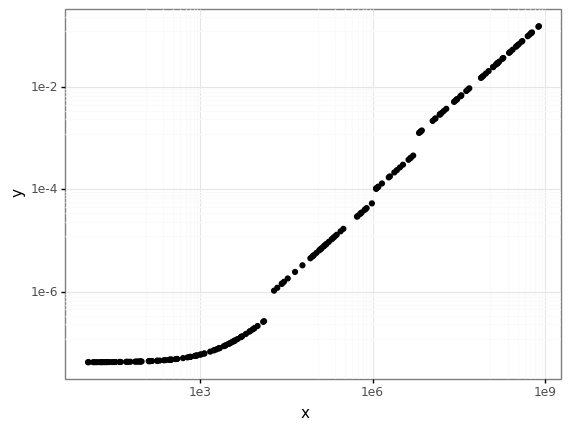

<ggplot: (8727738765751)>

In [2]:
def model(x):
    if x <= 1.450e+04:
        y = 1.739e-11*x + 4.181e-08
    elif x <= 9.925e+05:
        y = 5.457e-11*x
    elif x <= 5.630e+06:
        y = 8.929e-11*x
    else:
        y = 1.935e-10*x + 1.294e-05
    return y

N = 200
numpy.random.seed(42)
x = 10**numpy.random.uniform(1, 9, N)
y = numpy.array(list(map(model, x)))
df = pandas.DataFrame({'x': x, 'y': y})
(ggplot(df)
    + aes(x='x', y='y')
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)

-inf < x ≤ 1.287e+04
	y ~ 1.739e-11x + 4.181e-08
1.287e+04 < x ≤ 9.691e+05
	y ~ 5.457e-11x + 3.388e-21
9.691e+05 < x ≤ 5.081e+06
	y ~ 8.929e-11x + 5.421e-20
5.081e+06 < x ≤ inf
	y ~ 1.935e-10x + 1.294e-05


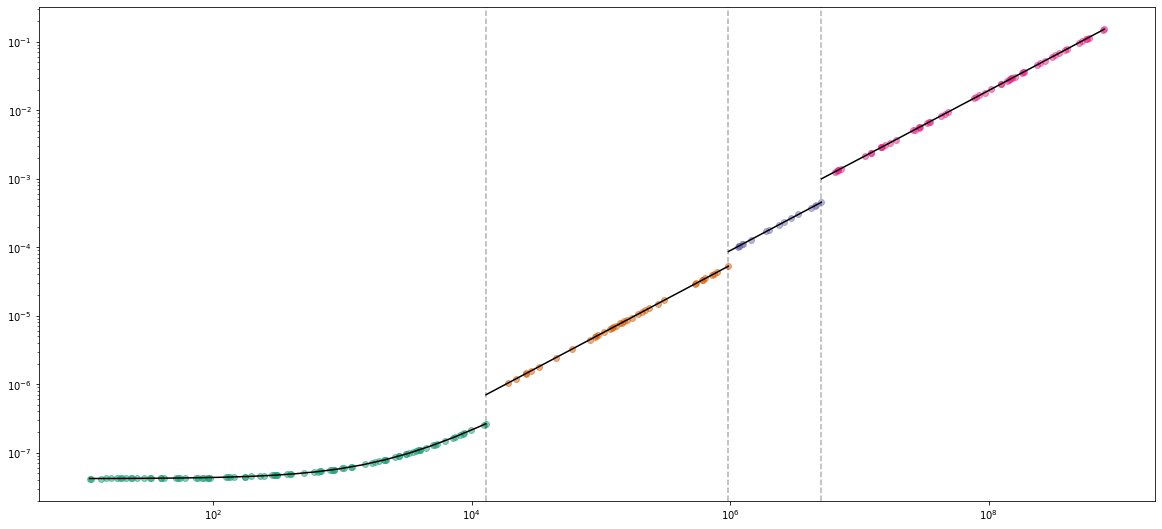

In [3]:
reg = pycewise.compute_regression(df['x'], df['y'], mode='log').auto_simplify()
print(reg)
reg.plot_dataset(log=True)

In [4]:
def compute_df_pred(df_data, mode):
    numpy.random.seed(42)
    df = pandas.DataFrame({'x':10**numpy.random.uniform(1, 9, 1000), 'mode':mode})
    if mode == 'datadog':
        reg = piecewise(df_data['x'], df_data['y'])
        df['y'] = df.apply(lambda row: reg.predict(row['x']), axis=1)
        breaks = [seg.end_t for seg in reg.segments[:-1]]
    else:
        reg = pycewise.compute_regression(df_data['x'], df_data['y'], mode=mode).auto_simplify()
        df['y'] = df.apply(lambda row: reg.predict(row['x']), axis=1)
        breaks = reg.breakpoints
    df['segment'] = 0
    for i, bp in enumerate(breaks):
        df.loc[df['x'] > bp, 'segment'] = i+1
    return df

df['noise'] = 'no noise'
pred_nonoise = pandas.concat([compute_df_pred(df, mode) for mode in ['BIC', 'weighted', 'log', 'datadog']])
pred_nonoise['noise'] = 'no noise'

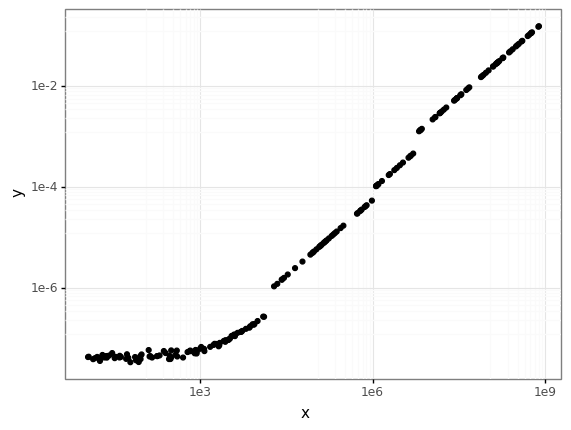

<ggplot: (8727731340471)>


In [5]:
df_homoscedastic = df.copy()
df_homoscedastic['noise'] = 'homoscedastic'
numpy.random.seed(42)
df_homoscedastic['y'] += numpy.random.normal(0, 5e-9, len(df))
print(ggplot(df_homoscedastic)
    + aes(x='x', y='y')
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)
pred_homoscedastic = pandas.concat([compute_df_pred(df_homoscedastic, mode) for mode in ['BIC', 'weighted', 'log', 'datadog']])
pred_homoscedastic['noise'] = 'homoscedastic'

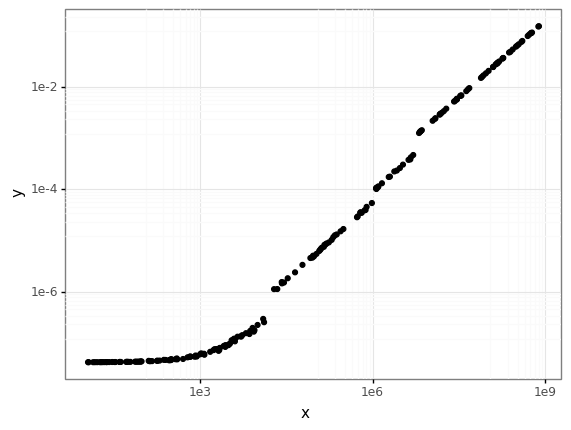

<ggplot: (-9223363309123475389)>


In [6]:
df_heteroscedastic = df.copy()
df_heteroscedastic['noise'] = 'heteroscedastic'
numpy.random.seed(42)
df_heteroscedastic['y'] += numpy.random.normal(0, 2e-12, len(df)) * df['x']
print(ggplot(df_heteroscedastic)
    + aes(x='x', y='y')
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)
pred_heteroscedastic = pandas.concat([compute_df_pred(df_heteroscedastic, mode) for mode in ['BIC', 'weighted', 'log', 'datadog']])
pred_heteroscedastic['noise'] = 'heteroscedastic'

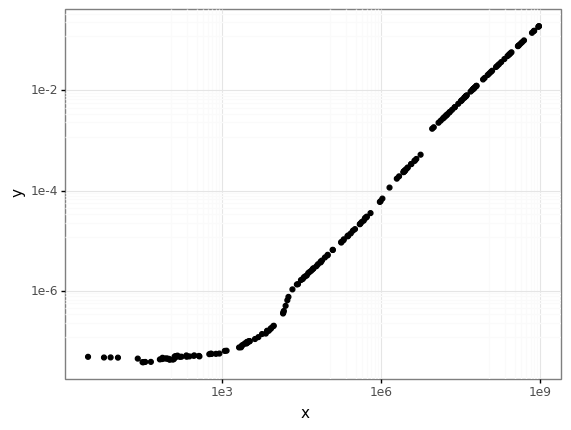

<ggplot: (8727731292585)>


In [7]:
df_real = pandas.read_csv('../data/prediction/modeling/network/pycewise/memcpy_small.csv')
df_real.columns = ['x', 'y']
df_real['noise'] = 'real data'
print(ggplot(df_real)
    + aes(x='x', y='y')
    + geom_point()
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw()
)
pred_real = pandas.concat([compute_df_pred(df_real, mode) for mode in ['BIC', 'weighted', 'log', 'datadog']])
pred_real['noise'] = 'real data'

In [8]:
data = pandas.concat([df, df_homoscedastic, df_heteroscedastic, df_real])
predictions = pandas.concat([pred_nonoise, pred_homoscedastic, pred_heteroscedastic, pred_real])

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R -i data

library(dplyr)
library(ggplot2)
library(Cubist)

data = data %>%
    mutate(noise=factor(noise, levels=c("no noise", "homoscedastic", "heteroscedastic", "real data")))

str(data)

R[write to console]: 
Attachement du package : ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Le chargement a nécessité le package : lattice



'data.frame':	800 obs. of  3 variables:
 $ x    : num  9.92e+03 4.03e+08 7.18e+06 6.16e+05 1.77e+02 ...
 $ y    : num  2.14e-07 7.81e-02 1.40e-03 3.36e-05 4.49e-08 ...
 $ noise: Factor w/ 4 levels "no noise","homoscedastic",..: 1 1 1 1 1 1 1 1 1 1 ...


In [11]:
%%R -i predictions

str(predictions)

'data.frame':	16000 obs. of  5 variables:
 $ x      : num  9.92e+03 4.03e+08 7.18e+06 6.16e+05 1.77e+02 ...
 $ mode   : chr  "BIC" "BIC" "BIC" "BIC" ...
 $ y      : num  2.14e-07 7.81e-02 1.40e-03 3.36e-05 4.49e-08 ...
 $ segment: int  0 3 3 1 0 0 0 3 1 2 ...
 $ noise  : chr  "no noise" "no noise" "no noise" "no noise" ...


In [12]:
%%R

pred_cubist = data.frame()

for(noise_fct in c("no noise")) { #data %>% pull(noise) %>% unique()) {
    tmp_data = data %>% filter(noise==noise_fct)
    reg = cubist(x=data[c('x')], y=data$y)
    tmp_pred = predictions %>% filter(noise==noise_fct, mode=="log") %>% select(x)
    tmp_pred$y = predict(reg, tmp_pred[c('x')])
    breaks = reg$splits %>% filter(dir == "<=") %>% pull(value)
    tmp_pred$segment = 0
    for(i in 1:length(breaks)) {
        b = breaks[i]
        tmp_pred = tmp_pred %>% mutate(segment=ifelse(x > b, i, segment))
    }
    tmp_pred$mode = "cubist"
    tmp_pred$noise = noise_fct
    pred_cubist = rbind(pred_cubist, tmp_pred)
}

str(pred_cubist)

'data.frame':	1000 obs. of  5 variables:
 $ x      : num  9.92e+03 4.03e+08 7.18e+06 6.16e+05 1.77e+02 ...
 $ y      : num  5.24e-07 7.83e-02 1.39e-03 1.18e-04 0.00 ...
 $ segment: num  0 0 0 0 0 0 0 0 0 0 ...
 $ mode   : chr  "cubist" "cubist" "cubist" "cubist" ...
 $ noise  : chr  "no noise" "no noise" "no noise" "no noise" ...


In [13]:
%%R

summary(reg)


Call:
cubist.default(x = data[c("x")], y = data$y)


Cubist [Release 2.07 GPL Edition]  Sun Feb 14 10:00:39 2021
---------------------------------

    Target attribute `outcome'

Read 800 cases (2 attributes) from undefined.data

Model:

  Rule 1: [792 cases, mean 0.0082988, range 3.306283e-08 to 0.149017, est err 0.0000873]

    if
	x <= 7.677213e+08
    then
	outcome = -1.4e-06 + 1.94e-10 x

  Rule 2: [8 cases, mean 0.1662956, range 0.1509761 to 0.1909646, est err 0.0022217]

    if
	x > 7.677213e+08
    then
	outcome = -0.0138961 + 2.13e-10 x


Evaluation on training data (800 cases):

    Average  |error|          0.0001001
    Relative |error|               0.01
    Correlation coefficient        1.00


	Attribute usage:
	  Conds  Model

	  100%   100%    x


Time: 0.0 secs



In [14]:
%%R

predictions = rbind(predictions, pred_cubist)

predictions = predictions %>%
    mutate(mode=ifelse(mode=="BIC", "ordinary", mode)) %>%
    mutate(mode=factor(mode, levels=c("datadog", "cubist", "ordinary", "weighted", "log")))
predictions = predictions %>%
    mutate(noise=factor(noise, levels=c("no noise", "homoscedastic", "heteroscedastic", "real data")))
str(predictions)

'data.frame':	17000 obs. of  5 variables:
 $ x      : num  9.92e+03 4.03e+08 7.18e+06 6.16e+05 1.77e+02 ...
 $ mode   : Factor w/ 5 levels "datadog","cubist",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ y      : num  2.14e-07 7.81e-02 1.40e-03 3.36e-05 4.49e-08 ...
 $ segment: num  0 3 3 1 0 0 0 3 1 2 ...
 $ noise  : Factor w/ 4 levels "no noise","homoscedastic",..: 1 1 1 1 1 1 1 1 1 1 ...


`summarise()` regrouping output by 'noise' (override with `.groups` argument)
`summarise()` regrouping output by 'noise', 'mode' (override with `.groups` argument)


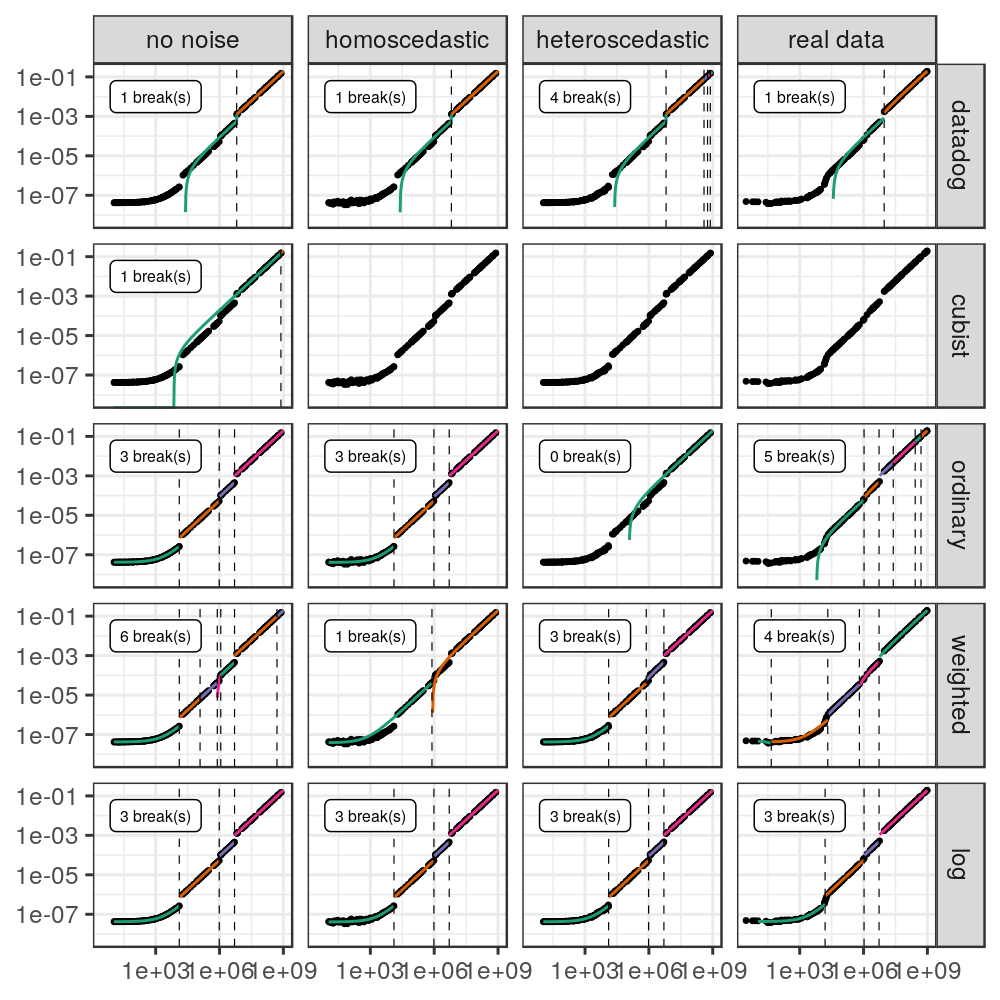

In [15]:
%%R -w 5 -h 5 --units in -r 200

nb_breaks = predictions %>%
    group_by(noise, mode) %>%
    summarise(nb=paste(max(segment), "break(s)")) %>%
    mutate(x=1e3, y=1e-2) %>%
    ungroup()

breaks = predictions %>%
    group_by(noise, mode, segment) %>%
    summarise(breaks=max(x)) %>%
    group_by(noise, mode) %>%
    filter(breaks < max(breaks))

plot = ggplot() +
    aes(x=x, y=y) +
    geom_point(data=data, size=0.5) +
    geom_line(data=predictions %>% arrange(x), aes(group=segment, color=factor(segment %% 4))) +
    geom_vline(data=breaks, aes(xintercept=breaks), linetype="dashed", size=0.2) +
    geom_label(data=nb_breaks, aes(label=nb), color="black", size=2) +
    facet_grid(mode~noise) +
    scale_x_log10() +
    scale_y_log10() +
    theme_bw() +
    scale_color_brewer(palette="Dark2") +
    theme(legend.position='none') +
    theme(axis.title.x=element_blank(), axis.title.y=element_blank())
ggsave(filename='../img/prediction/modeling/network/pycewise.pdf', plot=plot, width=7, height=5)
plot